<h1>Assignment 3</h1>

Florian Klement, David Siegl

In [13]:
import igraph
import pandas as pd
import tweepy
import oauth2 as oauth
import math

<h2>Data Preparation</h2>

In [2]:
api_key = "X"
api_secret = "X"
access_token_key = "X-X"
access_token_secret = "X"

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [36]:
#tweets_list = tweepy.Cursor(api.search_tweets, q="#musk", tweet_mode='extended').items(1000)

In [37]:
# output = []
# for tweet in tweets_list:
#     text = tweet._json["full_text"]
#     favourite_count = tweet.favorite_count
#     retweet_count = tweet.retweet_count
#     created_at = tweet.created_at
#     language = tweet.lang
#     is_retweet = tweet.retweeted
#     user_name = tweet.user.screen_name
    
    
#     line = {"text" : text, "favourite_count" : favourite_count, "retweet_count" : retweet_count, "created_at" : created_at, "language" : language, "is_retweet": is_retweet, "user_name" : user_name}
#     output.append(line)
    
# df_tweets = pd.DataFrame(output)

In [38]:
# df_tweets.to_csv("tweets_musk.csv", header = ["text", "favourite_count", "retweet_count", "created_at", "language", "is_retweet", "user_name"])

In [14]:
df_tweets_elonmusk = pd.read_csv("tweets_elonmusk.csv", index_col = 0)
df_tweets_elonmusktwitter = pd.read_csv("tweets_elonmusktwitter.csv", index_col = 0)
df_tweets_musk = pd.read_csv("tweets_musk.csv", index_col = 0)
df_tweets_tesla = pd.read_csv("tweets_tesla.csv", index_col = 0)

In [15]:
df_tweets_elonmusk['hashtag'] = '#elonmusk'
df_tweets_elonmusktwitter['hashtag'] = '#elonmusktwitter'
df_tweets_musk['hashtag'] = '#musk'
df_tweets_tesla['hashtag'] = '#tesla'

In [16]:
df_tweets_all = pd.concat([df_tweets_elonmusk, df_tweets_elonmusktwitter, df_tweets_musk, df_tweets_tesla], ignore_index=False)

In [17]:
en_tweets = df_tweets_all.loc[(df_tweets_all["language"] == "en")]
en_tweets['rt_mentions'] = en_tweets['text'].str.extract(r'(RT @\w*:)')
en_tweets['mentions'] = en_tweets['text'].str.findall(r'(@\w*)+')
en_tweets['hashtags'] = en_tweets['text'].str.findall(r'(#\w*)+')
en_tweets['rt_mentions'] = en_tweets['rt_mentions'].str.replace(r'(RT @)', '')
en_tweets['rt_mentions'] = en_tweets['rt_mentions'].str.replace(r'(:)', '')

/tmp/ipykernel_7748/2970021013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_tweets['rt_mentions'] = en_tweets['text'].str.extract(r'(RT @\w*:)')
/tmp/ipykernel_7748/2970021013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_tweets['mentions'] = en_tweets['text'].str.findall(r'(@\w*)+')
/tmp/ipykernel_7748/2970021013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [43]:
ls = []
for i in range(1,16):
    ls.append('mentions_' + str(i))

In [44]:
en_tweets.index = range(len(en_tweets.index))

df_test = pd.DataFrame(en_tweets['mentions'].tolist())
df_test.columns = ls
en_tweets = en_tweets.merge(df_test, how='outer', left_index=True, right_index=True)

In [45]:
ls = []
for i in range(1,28):
    ls.append('hashtags_' + str(i))

In [46]:
df_test = pd.DataFrame(en_tweets['hashtags'].tolist())
df_test.columns = ls
en_tweets = en_tweets.merge(df_test, how='outer', left_index=True, right_index=True)

In [ ]:
en_tweets.to_csv("tweets_processed.csv")

<h2>Retweets Network</h2>

In [18]:
df_networks = pd.read_csv("tweets_processed.csv", index_col = 0)

In [19]:
df_network_onlytweets = df_networks[~df_networks["text"].str.startswith("RT", na = False)]
df_network_onlyrts = df_networks[df_networks["text"].str.startswith("RT", na = False)]

In [8]:
set_users = df_networks['user_name'].tolist()
set_users = set(set_users)

set_rt_mentions = df_networks['rt_mentions'].tolist()
set_rt_mentions = set(set_rt_mentions)

for name in set_rt_mentions:
    set_users.add(name)

user_count = len(set_users)

set_users = list(set_users)

df = pd.DataFrame(set_users)


In [9]:
g = igraph.Graph()
g.add_vertices(user_count)

g.vs['name'] = df[0]

In [10]:
list1 = df_network_onlyrts['rt_mentions'].tolist()
list2 = df_network_onlyrts['user_name'].tolist()

merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]

In [11]:
df_network_onlyrts.index = range(len(df_network_onlyrts.index))
g.add_edges(merged_list)
g.es["weight"] = 1
g.es["retweet_count"] = df_network_onlyrts['retweet_count']
g.es["created_at"] = df_network_onlyrts['created_at']
g.es["hashtags"] = df_network_onlyrts['hashtags']


In [12]:
g.vs['degree'] = g.degree()
max_degrees = g.get_vertex_dataframe().sort_values('degree')
max_degrees = max_degrees[-20:].sort_values('degree', ascending=False)

In [10]:
# users_list = max_degrees["name"].tolist()
# users = api.lookup_users(screen_name = users_list)

# output = []
# for user in users:
#     user_name = user.screen_name
#     user_id = user.id
#     favourite_count = user.favourites_count
#     followers_count = user.followers_count
#     is_verified = user.verified
#     friends_count = user.friends_count

#     line = {"user_name" : user_name, "user_id" : user_id, "favourite_count" : favourite_count, "followers_count" : followers_count, "is_verified" : is_verified, "friends_count" : friends_count}
#     output.append(line)
    
# df_users = pd.DataFrame(output)
# df_users.to_csv("users_maxdegrees_rt.csv")

In [11]:
df_users = pd.read_csv("users_maxdegrees_rt.csv", index_col = 0)
df_users

user_name              user_id  favourite_count  followers_count  \
0    FinTheSentence  1466008831356547079              161                1   
1    darkjournalist            255232449            11758            24132   
2   Willard_Austria   984166701880217603            64719              172   
3     JayinShanghai  1082181922606858241            21457            17629   
4        kirillklip            132288724           299926             7874   
5         Utoday_en   953559767242498049              683            56018   
6        moosechris             69791520             1256              865   
7   TheSizzleReport  1122396663811837952            99374            50378   
8         ll_AXE_ll  1386917808202604544            17009               46   
9     JohnPersinos1            384859207            10898             2848   
10   PawlowskiMario   968008274003005440           120105            30160   
11   MagicCraftGame  1440205262783070213             1452            77356   
12        SpheronHQ  1295797572682964992             2157            33656   
13     DrJDrooghaag           3429955204           337913            44454   
14     Web3Platform  1520883940843655168                6             3636   
15        Zxcxz_xyz  1096724430087208960             2585              213   
16          ttindia            141080858              222           302450   
17  MeseeksMobileGO  1145022642975461376            11336             4185   
18   stevenmarkryan             31263848             6880           117355   

    is_verified  friends_count  
0         False             12  
1         False            903  
2         False            129  
3         False            997  
4         False           7514  
5         False           4417  
6         False           1222  
7         False          31625  
8         False            310  
9         False           1119  
10        False          12078  
11         True             54  
12        False            733  
13        False          13540  
14        False             13  
15        False            944  
16         True            133  
17        False            576  
18        False            142

In [12]:
g.vs['betweenness'] = g.betweenness()
max_btw = g.get_vertex_dataframe().sort_values('betweenness')
max_btw = max_btw[-20:].sort_values('betweenness', ascending=False)

In [13]:
# users_list = max_btw["name"].tolist()
# users = api.lookup_users(screen_name = users_list)

# output = []
# for user in users:
#     user_name = user.screen_name
#     user_id = user.id
#     favourite_count = user.favourites_count
#     followers_count = user.followers_count
#     is_verified = user.verified
#     friends_count = user.friends_count

#     line = {"user_name" : user_name, "user_id" : user_id, "favourite_count" : favourite_count, "followers_count" : followers_count, "is_verified" : is_verified, "friends_count" : friends_count}
#     output.append(line)
    
# df_users = pd.DataFrame(output)
# df_users.to_csv("users_maxbtw_rt.csv")

In [14]:
df_users = pd.read_csv("users_maxbtw_rt.csv", index_col = 0)
df_users

user_name              user_id  favourite_count  followers_count  \
0     JayinShanghai  1082181922606858241            21457            17629   
1    darkjournalist            255232449            11758            24132   
2   Willard_Austria   984166701880217603            64719              172   
3        moosechris             69791520             1256              865   
4   TheSizzleReport  1122396663811837952            99374            50378   
5    stevenmarkryan             31263848             6880           117355   
6     RohanTheHuman   935317576204238850            24260              110   
7         Utoday_en   953559767242498049              683            56018   
8     rubyjean72802            589889711             8023              476   
9   FightClubTesla_  1507192920004304898              924               49   
10    Teslaconomics   985243593538338816            50523            38343   
11   PawlowskiMario   968008274003005440           120105            30160   
12  CurieuxExplorer  1249601030502756353           133846            21975   
13    JohnPersinos1            384859207            10898             2848   
14        ll_AXE_ll  1386917808202604544            17009               46   
15       chillFabio  1224822877133910016            10788               38   
16  occupymars42069  1246503261730938880            96288             1560   
17         pettet50           3194071636           106334             2661   
18       UpdateRail  1213508558546800640             5533              474   
19   MagicCraftGame  1440205262783070213             1452            77356   

    is_verified  friends_count  
0         False            997  
1         False            903  
2         False            129  
3         False           1222  
4         False          31625  
5         False            142  
6         False            157  
7         False           4417  
8         False           2198  
9         False            116  
10        False            189  
11        False          12078  
12        False           7678  
13        False           1119  
14        False            310  
15        False             77  
16        False            150  
17        False           2514  
18        False            384  
19         True             54

<h2>Mentions Network</h2>

In [20]:
df_networks = pd.read_csv("tweets_processed.csv", index_col = 0)

In [21]:
set_users = df_networks['user_name'].tolist()
set_users = set(set_users)

In [22]:
filter = df_networks['mentions'] != '[]'
df_onlymts = df_networks[filter]
filter = df_networks['mentions'] != '[@]'
df_onlymts = df_onlymts[filter]


set_mentions = df_onlymts['mentions']

set_mentions = ",".join(set_mentions)
set_mentions = set_mentions.replace("[", "")
set_mentions = set_mentions.replace("']", "")
set_mentions = set_mentions.replace("@", "")
set_mentions = set_mentions.replace("'", "")
set_mentions = set_mentions.replace(" ", "")
set_mentions = set_mentions.split(",")
set_mentions = set(set_mentions)
set_mentions.pop() #removing first blank entry

for name in set_mentions:
    set_users.add(name)

user_count = len(set_users)

set_users = list(set_users)

df = pd.DataFrame(set_users)

/tmp/ipykernel_7748/3874178985.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_onlymts = df_onlymts[filter]


In [23]:
g = igraph.Graph()
g.add_vertices(user_count)

g.vs['name'] = df[0]

In [24]:
for i in range(1,16):
    df_onlymts['mentions_' + str(i)] = df_onlymts['mentions_' + str(i)].str.replace('@', '')

In [25]:
ls = []
for i in range(1,16):
        tuples_mentions = list(zip(df_onlymts['user_name'], df_onlymts['mentions_' + str(i)]))
        ls.append(tuples_mentions)

tuples_mentions = [item for sublist in ls for item in sublist]

tuples_mentions = [t for t in tuples_mentions if not any(isinstance(n, float) and math.isnan(n) for n in t)]

tuples_mentions = set(tuples_mentions)
tuples_mentions = list(tuples_mentions)
tuples_mentions = [_ for _ in tuples_mentions if '' not in _]


In [21]:
g.add_edges(tuples_mentions)
g.es["weight"] = 1

In [22]:
g.vs['degree'] = g.degree()
max_degrees = g.get_vertex_dataframe().sort_values('degree')
max_degrees = max_degrees[-20:].sort_values('degree', ascending=False)

In [23]:
# users_list = max_degrees["name"].tolist()
# users = api.lookup_users(screen_name = users_list)

# output = []
# for user in users:
#     user_name = user.screen_name
#     user_id = user.id
#     favourite_count = user.favourites_count
#     followers_count = user.followers_count
#     is_verified = user.verified
#     friends_count = user.friends_count

#     line = {"user_name" : user_name, "user_id" : user_id, "favourite_count" : favourite_count, "followers_count" : followers_count, "is_verified" : is_verified, "friends_count" : friends_count}
#     output.append(line)
    
# df_users = pd.DataFrame(output)
# df_users.to_csv("users_maxdegree_mts.csv")

In [24]:
df_users = pd.read_csv("users_maxdegree_mts.csv", index_col = 0)
df_users

user_name              user_id  favourite_count  followers_count  \
0          elonmusk             44196397            13263         94077744   
1             Tesla             13298072             4202         15546273   
2           Twitter               783214             6243         61838149   
3     thor_artilary  1236182296048230400               67                8   
4   mysticinthemoon           1254963620            12303            10560   
5    darkjournalist            255232449            11758            24132   
6   Willard_Austria   984166701880217603            64719              172   
7        asifalij95   915868390643953664              185               70   
8     JayinShanghai  1082181922606858241            21457            17629   
9    worldcobaltday  1295690605226582017              102                6   
10   PawlowskiMario   968008274003005440           120105            30160   
11        FrRonconi           1409726425            24094            48696   
12        Utoday_en   953559767242498049              683            56018   
13        arwed2801             47065178             2719              209   
14         arikring             59386332           274079            89658   
15       moosechris             69791520             1256              865   
16  CurieuxExplorer  1249601030502756353           133846            21975   
17  TheSizzleReport  1122396663811837952            99374            50378   
18        ll_AXE_ll  1386917808202604544            17009               46   
19           SpaceX             34743251              388         22889074   

    is_verified  friends_count  
0          True            110  
1          True             78  
2          True              0  
3         False             31  
4         False            820  
5         False            903  
6         False            129  
7         False            953  
8         False            997  
9         False             21  
10        False          12078  
11        False           2363  
12        False           4417  
13        False            857  
14        False          61414  
15        False           1222  
16        False           7678  
17        False          31625  
18        False            310  
19         True            100

In [25]:
g.vs['betweenness'] = g.betweenness()
max_btw = g.get_vertex_dataframe().sort_values('betweenness')
max_btw = max_btw[-20:].sort_values('betweenness', ascending=False)

In [26]:
# users_list = max_btw["name"].tolist()
# users = api.lookup_users(screen_name = users_list)

# output = []
# for user in users:
#     user_name = user.screen_name
#     user_id = user.id
#     favourite_count = user.favourites_count
#     followers_count = user.followers_count
#     is_verified = user.verified
#     friends_count = user.friends_count

#     line = {"user_name" : user_name, "user_id" : user_id, "favourite_count" : favourite_count, "followers_count" : followers_count, "is_verified" : is_verified, "friends_count" : friends_count}
#     output.append(line)
    
# df_users = pd.DataFrame(output)
# df_users.to_csv("users_maxbtw_mts.csv")

In [27]:
df_users = pd.read_csv("users_maxbtw_mts.csv", index_col = 0)
df_users

user_name              user_id  favourite_count  followers_count  \
0          elonmusk             44196397            13264         94078017   
1             Tesla             13298072             4202         15546296   
2     thor_artilary  1236182296048230400               67                8   
3           Twitter               783214             6243         61838159   
4        todongpnoy  1174966206379331586             4912             1213   
5     JayinShanghai  1082181922606858241            21457            17629   
6    worldcobaltday  1295690605226582017              102                6   
7            nypost             17469289             1926          2689343   
8       EDCTechGear  1216962091053174785            11333              201   
9        asifalij95   915868390643953664              185               70   
10        FrRonconi           1409726425            24097            48696   
11        arwed2801             47065178             2719              209   
12  CurieuxExplorer  1249601030502756353           133846            21975   
13   DogecoinCyprus  1381896094922240000            34971              730   
14        Utoday_en   953559767242498049              683            56018   
15   education_24x7  1295715136141963267               18             7108   
16        mvollmer1             99674560           314584            98994   
17        ll_AXE_ll  1386917808202604544            17009               46   
18       cz_binance   902926941413453824            17001          6199544   

    is_verified  friends_count  
0          True            110  
1          True             78  
2         False             31  
3          True              0  
4         False           2262  
5         False            997  
6         False             21  
7          True          10988  
8         False            665  
9         False            953  
10        False           2363  
11        False            857  
12        False           7678  
13        False            528  
14        False           4417  
15        False              7  
16        False          81241  
17        False            310  
18         True           1796

<h2>Hashtags Network</h2>

In [2]:
df_networks = pd.read_csv("tweets_processed.csv", index_col = 0)

In [3]:
set_hashtags = df_networks['hashtags']

set_hashtags = ",".join(set_hashtags)
set_hashtags = set_hashtags.replace("[", "")
set_hashtags = set_hashtags.replace("]", "")
set_hashtags = set_hashtags.replace("'", "")
set_hashtags = set_hashtags.replace(" ", "")
set_hashtags = set_hashtags.split(",")
set_hashtags = set(set_hashtags)
set_hashtags.pop()

hashtags_count = len(set_hashtags)

set_hashtags = list(set_hashtags)

df = pd.DataFrame(set_hashtags)

In [4]:
g = igraph.Graph()
g.add_vertices(hashtags_count)

g.vs['name'] = df[0]

In [5]:
ls = []
for i in range(1,26):
    for j in range(2,27):
        tuples_mentions = list(zip(df_networks['hashtags_' + str(i)], df_networks['hashtags_' + str(j)]))
        ls += tuples_mentions

hashtags_cooc = ls

hashtags_cooc = [t for t in hashtags_cooc if not any(isinstance(n, float) and math.isnan(n) for n in t)]
hashtags_cooc = [_ for _ in hashtags_cooc if '' not in _]
hashtags_cooc = [(i,j) for i,j in hashtags_cooc if i != j]
hashtags_cooc = [(i,j) for i,j in hashtags_cooc if j != '#']

In [6]:
g.add_edges(hashtags_cooc)
g.es["weight"] = 1

In [7]:
communities = g.community_multilevel()

In [8]:
communities.summary()

'Clustering with 1983 elements and 45 clusters'

In [9]:
def subgraph_of_large_clusters(clustering: igraph.VertexClustering, threshold: int) -> igraph.VertexClustering:
    sizes = clustering.sizes()
    members = [i for i, c in enumerate(clustering.membership) if sizes[c] >= threshold]
    new_graph = clustering.graph.subgraph(members)
    new_membership = [clustering.membership[i] for i in members]
    return igraph.VertexClustering(new_graph, new_membership)

In [10]:
igraph.plot(subgraph_of_large_clusters(communities, 250), layout = 'fruchterman_reingold')

In [11]:
communities_subset = subgraph_of_large_clusters(communities, 250)
communities_subset.summary()

'Clustering with 1124 elements and 9 clusters'

In [1]:
# for i, community in enumerate(communities_subset):
#     print(f"Community {i}:")
#     for v in community:
#         print(f"\t{g.vs[v]['name']}")


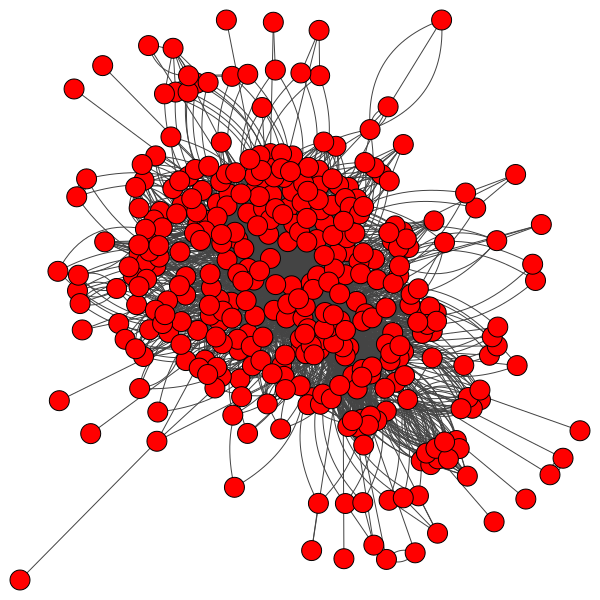

In [14]:
igraph.plot(communities_subset.subgraph(1), labels = False)

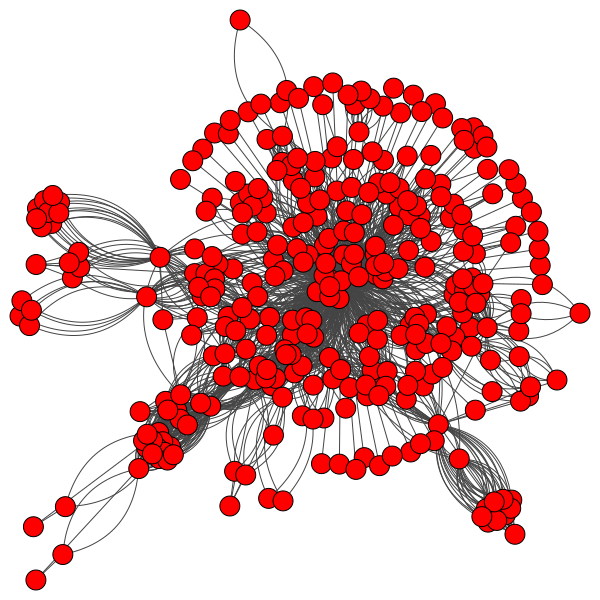

In [15]:
igraph.plot(communities_subset.subgraph(2), labels = False)

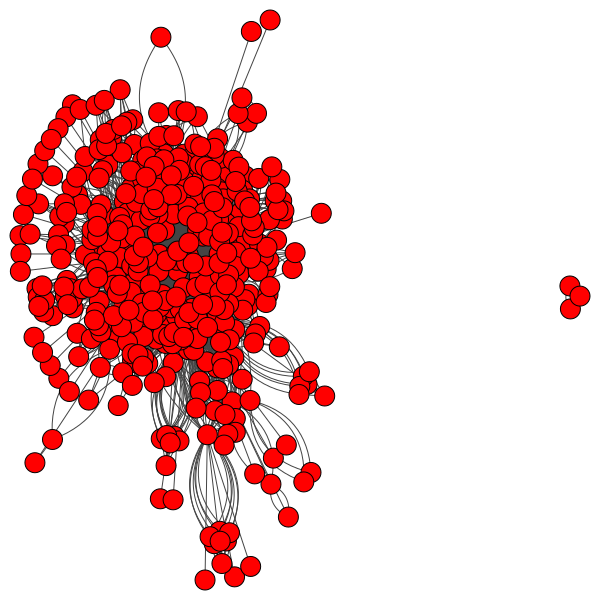

In [21]:
igraph.plot(communities_subset.subgraph(8), labels = False)